# Clustering Yelp Restaurants

**Part 2: To be completed INDIVIDUALLY and due on October 20 at 5pm.**

In this assignment, we will continue to work with the [Yelp dataset](https://www.yelp.com/dataset/challenge) that we used in Homework 2-1. Download the data from Round 10. You can find the format of the dataset [here](https://www.yelp.com/dataset/documentation/json).

We will continue to try to find culinary districts in Las Vegas. 

(As a reminder from last time, these are characterized by closeness and similarity of restaurants. Use the "longitude" and "latitude" to cluster closeness.)

However, in this analysis we will not use the Yelp-supplied "categories" to cluster for similarity as we did in Part 1.

Instead we will cluster the reviews themselves, extracting categories in an unsupervised fashion.  

Specifically, you are to use Latent Semantic Analysis (LSA) on the Yelp reviews to cluster restaurants based off on their reviews.  As a reminder, LSA consists of using PCA applied to the document-term matrix.

LSA was covered in lecture, and there is another tutorial [here.](http://www.datascienceassn.org/sites/default/files/users/user1/lsa_presentation_final.pdf
)

**(20 pts)**

In [7]:
import json
import random
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import Normalizer
from sklearn.utils.extmath import randomized_svd
from sklearn import metrics
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

-


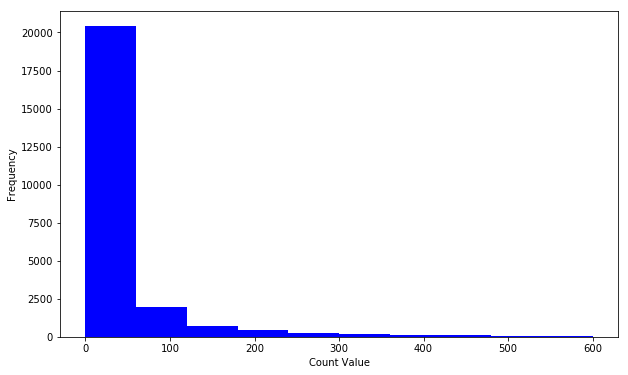

In [13]:
# Parse the data set
data_business = []
with open('business.json') as f:
    for line in f:
        data_business.append(json.loads(line))
        
data_business_loc = [items for items in data_business if items['city'] == 'Las Vegas']
data_business = [items["business_id"] for items in data_business if items['city'] == 'Las Vegas']

# Create a dict that stores all the business_id in LA
dct = {}
for item in data_business:
    if item in dct:  
        dct[item] = dct[item] + 1  
    else:  
        dct[item] = 1  
        
data_review = []
with open('review.json') as f:
    for line in f:
        data_review.append(json.loads(line))

data_review = [items for items in data_review if items["business_id"] in dct]

dct_review = {}
for item in data_review:
    if item["business_id"] in dct_review:
        dct_review[item["business_id"]] = dct_review[item["business_id"]] + 1 
    else:
        dct_review[item["business_id"]] = 1  

# store all values in dct_review into review_list and build a histogram
# and we can see most of returants have less than 50 reviews and few of them have more than 100 reviews
review_list = list(dct_review.values())
fig = plt.figure(figsize=(10,6))
plt.hist(review_list, range=[0, 600], facecolor='blue', align='mid')
plt.xlabel("Count Value")
plt.ylabel("Frequency")
print("-")
plt.show()

In [14]:
# Since the size of data_review is big, I will shuffle it and take it amount up to my Computer's computing power
random.seed(100)
size = len(data_review)
num = list(np.random.choice(size, int(size / 50), replace = False))
final_review_list = [data_review[item] for item in num]
data_review_list = [items['text'] for items in final_review_list]

# Extra locations coordinates
lon_dict = {}
for item in data_business_loc:
    if item["business_id"] in lon_dict:
        pass
    else:
        lon_dict[item["business_id"]] = item['longitude']

lat_dict = {}
for item in data_business_loc:
    if item["business_id"] in lat_dict:
        pass
    else:
        lat_dict[item["business_id"]] = item['latitude']

data_lat = [lat_dict[items["business_id"]] for items in final_review_list]
data_lon = [lon_dict[items["business_id"]] for items in final_review_list] 
loc = pd.DataFrame(data_lat,columns = ['latitude'])
loc.insert(1,'longitude',data_lon)

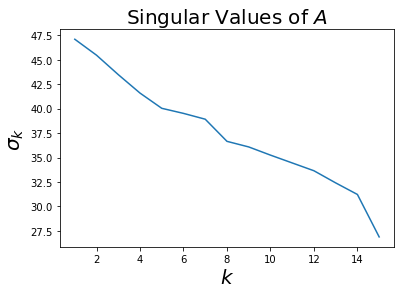

In [ ]:
# LSA
vectorizer = TfidfVectorizer(stop_words='english', min_df=3, max_df=0.8, max_features = 15)
dtm = vectorizer.fit_transform(data_review_list)
pd.DataFrame(dtm.toarray(),index = data_review_list, columns = vectorizer.get_feature_names()).head(15)
dtm_dense = dtm.todense()
centered_dtm = dtm_dense - np.mean(dtm_dense, axis=0)

# Singular value decomposition 
u, s, vt = randomized_svd(centered_dtm, n_components=15 , n_iter=5, random_state=None)

# Choose first K components based on the graph (First 14 components seems to to be good fits)
fig = plt.figure(figsize=(6,4))
plt.plot(range(1,1+len(s)),s)
plt.xlabel(r'$k$',size=20)
plt.ylabel(r'$\sigma_k$',size=20)
_ = plt.title(r'Singular Values of $A$',size=20)
plt.show()

df = pd.DataFrame(vt,columns=vectorizer.get_feature_names())
scopy = s.copy()
scopy[14:]=0
new_df = pd.DataFrame(u.dot(np.diag(scopy)).dot(vt))

# Add Lon and Lat into the orginal matrix to form new_df, and data preperation part is completed
new_df = pd.concat([loc,new_df], axis=1)

Find clusters using the 3 different techniques we discussed in class: k-means++, hierarchical, and GMM. Visualize the clusters by plotting the longitude/latitude of the restaurants in a scatter plot and label each cluster. 

Note that to label each cluster, you will need to think about how to extract labels from the LSA results.
**(25 pts)**

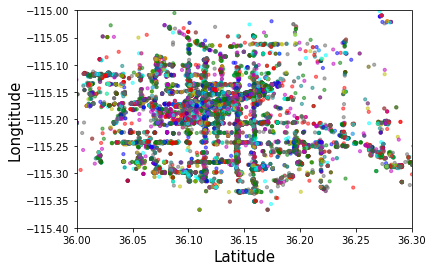

In [6]:
# K-means
from sklearn.cluster import KMeans
def evaluate_clusters(X,max_clusters):
    error = np.zeros(max_clusters+1)
    error[0] = 0;
    for k in range(1,max_clusters+1):
        kmeans = KMeans(init='k-means++', n_clusters=k, n_init=10)
        kmeans.fit_predict(X)
        error[k] = kmeans.inertia_
    plt.plot(range(1,len(error)),error[1:])
    plt.xlabel('Number of clusters')
    plt.ylabel('Error')
    
evaluate_clusters(new_df,20)
# We take K = 10 clusters

kmeans = KMeans(init='k-means++', n_clusters=10, n_init=10)
assign = kmeans.fit_predict(new_df)

LABEL_COLOR_MAP = {0 :'red', 1:'k', 2:'blue', 3:'green', 4:'y',
                  5:'dimgrey', 6:'green', 7:'cyan', 8:'teal', 9:'m'}

label_color = [LABEL_COLOR_MAP[l] for l in assign]
plt.scatter(loc.iloc[:,0],loc.iloc[:,1], s = 10, c = label_color, marker = 'o',alpha=0.5)
plt.xlim(36, 36.3)
plt.ylim(-115.4,-115)
plt.xlabel('Latitude',size=15)
plt.ylabel('Longtitude',size=15)
plt.show()

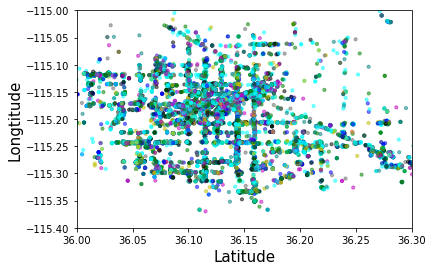

In [ ]:
# Hierarchical
import scipy.cluster.hierarchy as hierarchy
Z_20ng = hierarchy.linkage(new_df, method='ward', metric='euclidean')
#plt.figure(figsize=(14,4))
#R_20ng = hierarchy.dendrogram(Z_20ng, p=4, truncate_mode='level', show_leaf_counts=True)
clusters = hierarchy.fcluster(Z_20ng, 10, criterion='maxclust')
LABEL_COLOR_MAP_hi = {1 : 'red', 2 : 'k', 3 : 'blue', 4 : 'green', 5 : 'y',
                      6:'dimgrey', 7:'green', 8:'cyan', 9:'teal', 10:'m'}

label_color_hi = [LABEL_COLOR_MAP_hi[l] for l in clusters]
plt.scatter(loc.iloc[:,0],loc.iloc[:,1], s = 10, c = label_color_hi, marker = 'o',alpha=0.5)
plt.xlim(36, 36.3)
plt.ylim(-115.4,-115)
plt.xlabel('Latitude',size=15)
plt.ylabel('Longtitude',size=15)
plt.show()

/Users/CJ/anaconda/lib/python3.6/site-packages/sklearn/utils/deprecation.py:52: DeprecationWarning: Class GMM is deprecated; The class GMM is deprecated in 0.18 and will be  removed in 0.20. Use class GaussianMixture instead.
  warnings.warn(msg, category=DeprecationWarning)
/Users/CJ/anaconda/lib/python3.6/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning: Function distribute_covar_matrix_to_match_covariance_type is deprecated; The functon distribute_covar_matrix_to_match_covariance_typeis deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)
/Users/CJ/anaconda/lib/python3.6/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)
/Users/CJ/anaconda/lib/python3.6/site-packages/sklearn/utils/deprecation.py:70: Deprecat

/Users/CJ/anaconda/lib/python3.6/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)
/Users/CJ/anaconda/lib/python3.6/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)
/Users/CJ/anaconda/lib/python3.6/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)
/Users/CJ/anaconda/lib/python3.6/site-packages/sklearn/utils/deprecation.py:70: DeprecationWar

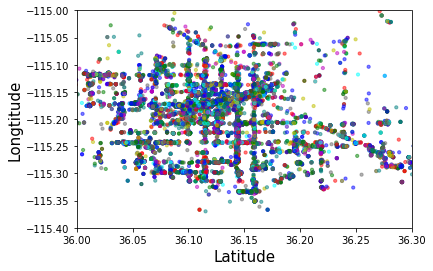

In [ ]:
# GMM
from sklearn import mixture
gmm = mixture.GMM(n_components=10, covariance_type='full')
gmm.fit(new_df)
y_pred = gmm.predict(new_df)
label_color_GMM = [LABEL_COLOR_MAP[p] for p in y_pred]
plt.scatter(loc.iloc[:,0], loc.iloc[:,1], s = 10, c = label_color_GMM, marker = 'o', alpha=0.5)
plt.xlim(36, 36.3)
plt.ylim(-115.4,-115)
plt.xlabel('Latitude',size=15)
plt.ylabel('Longtitude',size=15)
plt.show()

Compare your clusters with the results you obtained in Part 1. Use cluster comparison metrics, and also comment on which clustering appears (from your inspection of the clusters) to be more informative, and why. **(15 pts)**

In [ ]:
'''def sc_evaluate_clusters(X,max_clusters):
    s = np.zeros(max_clusters+1)
    s[0] = 0;
    s[1] = 0;
    for k in range(2,max_clusters+1):
        kmeans = KMeans(init='k-means++', n_clusters=k, n_init=10)
        assign = kmeans.fit_predict(X)
        s[k] = metrics.silhouette_score(X,assign,metric='euclidean')
        plt.plot(range(2,len(s)),s[2:])
        plt.xlabel('Number of clusters')
        plt.ylabel('Silhouette_score')
sc_evaluate_clusters(new_df,10)'''

The Silhouette Coefficient is an example of such an evaluation, where a higher Silhouette Co-
efficient score relates to a model with "better defined" clusters. (sklearn.metrics.silhouette_score)
Let a be the mean distance between a data point and all other points in the same cluster.
Let b be the mean distance between a data point and all other points in the next nearest cluster. Then the Silhouette Coefficient for a clustering is:
s= (b - a) / max(a, b)

Here I am doing the best I can as my kernel dies when running metrics.silhoutette_score. The technique, however is basically to use the cluster comparison metrics above to generate silhoutette_score graphs for both hw2.1 and hw2.2. Although my system fails to produce a result, I expect I get a bigger silhoutette_score value from hw2.2 than that from hw2.1 on the grounds that clustering based on reviews generates better defined clusters than clustering based on categories. I believe K-means ++ and GMM produce to be more informative and less computational expensive as hierarchical took so much time to run. 

----------